<a href="https://colab.research.google.com/github/andrequant/Aleatorios_Python/blob/master/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
# Andre Lorenzo Bittencourt - 5586161

### Assume the model:

$\ddot{q}(t) + \gamma \dot{q}(t) + \omega^2 q(t) = 0$

Where $q(t) \in \mathbb{R}$ is the position at time $t$.

### Exercise 1.1

#### Reformulate the ODE as a first-orde ODE for $x(t) = \begin{bmatrix} q(t) \\ v(t) \end{bmatrix}$, with constant coeficients $A \in \mathbb{R}^{2 \times 2}$.

#### Write down the explicit and implicit Euler discretiations.

### Solution 1.1



Rearrange the original ODE as $$ \ddot{q}(t) = -\gamma \dot{q}(t) - \omega^2 q(t) $$

We want to write $$\dot{x}(t) = A x(t)$$

therefore $$ \dot{x}(t) = \begin{bmatrix} \dot{q}(t) \\ \ddot{q}(t) \end{bmatrix} = A \begin{bmatrix} {q}(t) \\ \dot{q}(t) \end{bmatrix}$$

So, $$\dot{x}(t) = \begin{bmatrix} \dot{q}(t) \\ -\gamma \dot{q}(t) - \omega^2 q(t) \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -\omega^2 & -\gamma \end{bmatrix} \begin{bmatrix} {q}(t) \\ \dot{q}(t) \end{bmatrix} = Ax(t)$$


Remembering, the implicit (or backward) Euler discretisation take the form $$x_{t+\tau} =  x_t + τ \dot{x}_{t+\tau} $$
and the explicit (or forward) is $$x_{t+\tau} =  x_t + \tau \dot{x}_{t} $$

Hence, the explicit discretisation for our problem is

$$ x(t+\tau) =  x(t) + \tau Ax(t)$$

and implicit is
$$ x(t+\tau) =  x(t) + \tau Ax(t+\tau)$$

$$x(t) = -\tau Ax(t+\tau) + x(t+\tau) $$
$$ x(t) = (I - \tau A)x(t+\tau) $$
Finally,
$$ x(t + \tau) = (I - \tau A)^{-1}x(t)$$

for some $x(0) = x_0$.


### Exercise 1.2
#### Implement the implicit Euler solver and solve the problem over $t \in [0,5]$, for $x(0) = (1,2)$, $\gamma = 0.2$, $\omega = 1$ and $\tau = 0.01$.

### Solution 1.1

In [244]:
import numpy as np
import matplotlib.pyplot as plt

In [245]:
### Parameters

omega = 1
gamma = 0.2
tau = 0.01
x0 = np.array([1,2])
T = 5
A = np.array([[0,1],[-omega*omega, -gamma]])

In [246]:
### Implicit Euler scheme

def implicit_euler(x0, A, tau, T):
  n = int(T/tau)
  x = np.empty(shape=(n+1,2))
  x[0] = x0
  I = np.identity(len(A), dtype=int)

  for i in range(n):
    a = I - tau*A
    x[i+1] = np.linalg.solve(a,x[i])

  return x

In [247]:
x = implicit_euler(x0, A, tau, T)

In [248]:
x

array([[ 1.        ,  2.        ],
       [ 1.0198583 ,  1.98582976],
       [ 1.03957321,  1.97149104],
       ...,
       [-1.07711818,  0.97438209],
       [-1.06728729,  0.98308879],
       [-1.0573705 ,  0.99167913]])

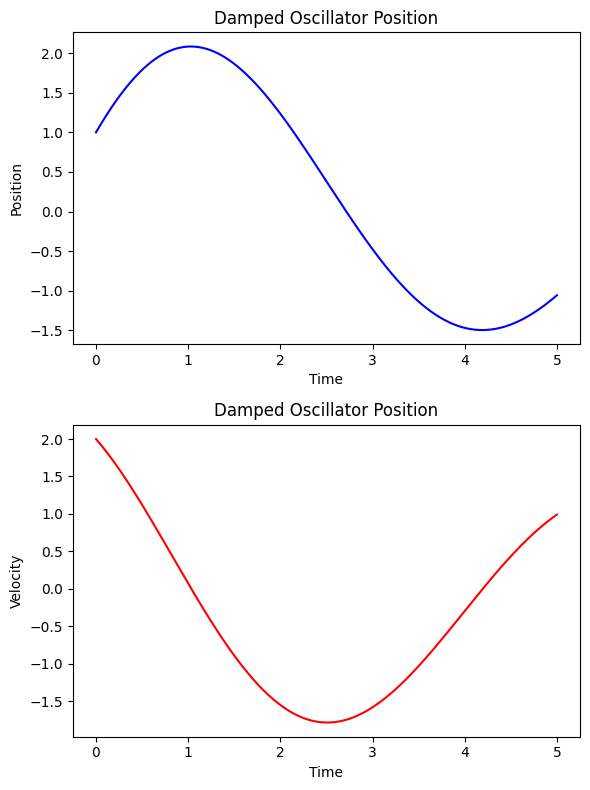

In [261]:
### Plot the system

time = np.arange(0, T+tau, tau)

# Create plot side-by-side
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Plot the postion time series in the first subplot
axs[0].plot(time, x.T[0], label='Position', color='blue')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')
axs[0].set_title('Damped Oscillator Position')


# Plot the velocity in the second subplot
axs[1].plot(time, x.T[1], label='Velocity', color='red')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Velocity')
axs[1].set_title('Damped Oscillator Position')

plt.tight_layout()
plt.show()

$\newpage$

### Exercise 1.3

Suppose a noisy observation of position accordingly to $y(t) = Hx(t) + \eta(t)$, but observations are only made at times multiple of 0.1 and not at $t=0$.

Assume $$ H = \begin{bmatrix} 1 & 0\end{bmatrix}$$ and $$\eta \sim N(0,1)$$

Generate the synthetic data following this assumptions.

### Solution 1.3

In [250]:
### Create the noisy observation serie

random_normal = np.random.standard_normal(int((T/tau)/10))
H = np.array([1,0])
synthetic_x = np.matmul(x,H)[1::10] + random_normal

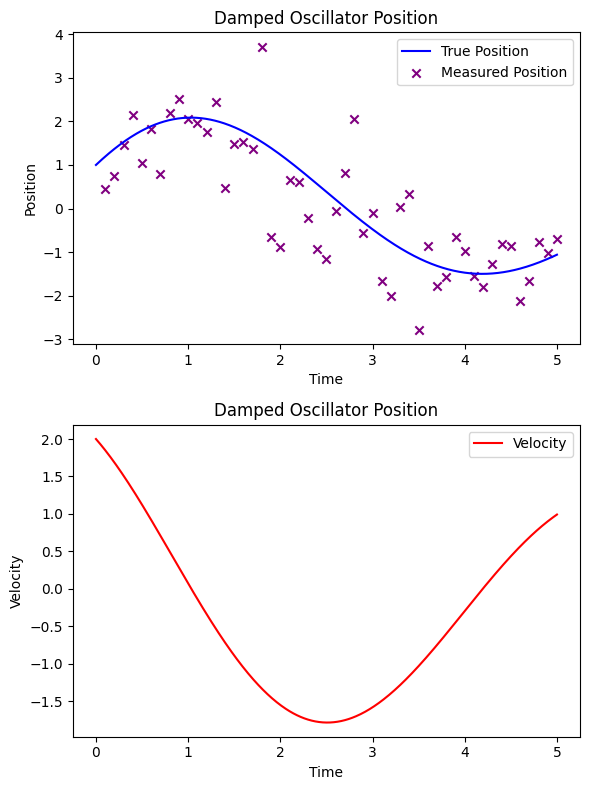

In [262]:
### Plot the "measurements" along side the true values

time2 = np.arange(0.1, T+tau, tau*10)

# Create plot side-by-side
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Plot the postion time series in the first subplot
axs[0].plot(time, x.T[0], label='True Position', color='blue')
axs[0].scatter(time2, synthetic_x, label='Measured Position', color='purple', marker='x')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')
axs[0].set_title('Damped Oscillator Position')
axs[0].legend()

# Plot the velocity in the second subplot
axs[1].plot(time, x.T[1], label='Velocity', color='red')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Velocity')
axs[1].set_title('Damped Oscillator Position')
axs[1].legend()

plt.tight_layout()
plt.show()

### Exercise 1.4

Implement a Linear Kalman Filter, with initial states estimates $\hat{m}(0) = (0,0)$ and $\hat{C}(0) = 10 I$ and correct system parameters $\gamma = 0.2$ and $\omega = 1$.

Plot the true solution, observed data and LKF estimation with credible regions.

### Solution 1.4

In [252]:
### Linear Kalman Filter Implementation

def LKF(init_m, init_c, transition_matrix, observation_matrix, observed_data, R):

  m_hat = init_m
  c_hat = init_c
  c_bar = init_c

  # Initialize estimation vector
  x_estimation = []
  x_estimation.append(m_hat)

  # Initialize 'deviation' vector
  x_deviation = []
  x_deviation.append([c_hat[0,0], c_hat[1,1]])

  for i in range(len(observed_data)):

    ### Physics-based prediction
    m_bar = transition_matrix @ m_hat
    c_bar = transition_matrix @ c_bar @ transition_matrix.T


    ### Observation conditioning
    m_hat = m_bar + c_bar @ observation_matrix.T * ((observation_matrix @ (c_bar @ observation_matrix.T) + R)**(-1) * (observed_data[i] - observation_matrix @ m_bar))
    c_hat = c_bar - c_bar @ observation_matrix.T * (observation_matrix @ (c_bar @ observation_matrix.T) + R)**(-1) * observation_matrix @ c_bar

    x_estimation.append(m_hat)
    x_deviation.append([c_hat[0,0], c_hat[1,1]])


  return np.array(x_estimation), np.array(x_deviation)

In [253]:
### Estimation

m = np.array([0,0])
C = np.array([[10,0],[0,10]])
tau2 = 0.1
transition_matrix = np.linalg.inv(np.identity(len(A)) - tau2*A)
observation_matrix = np.array([1,0])


est, dev = LKF(m, C, transition_matrix, observation_matrix, synthetic_x, 1)

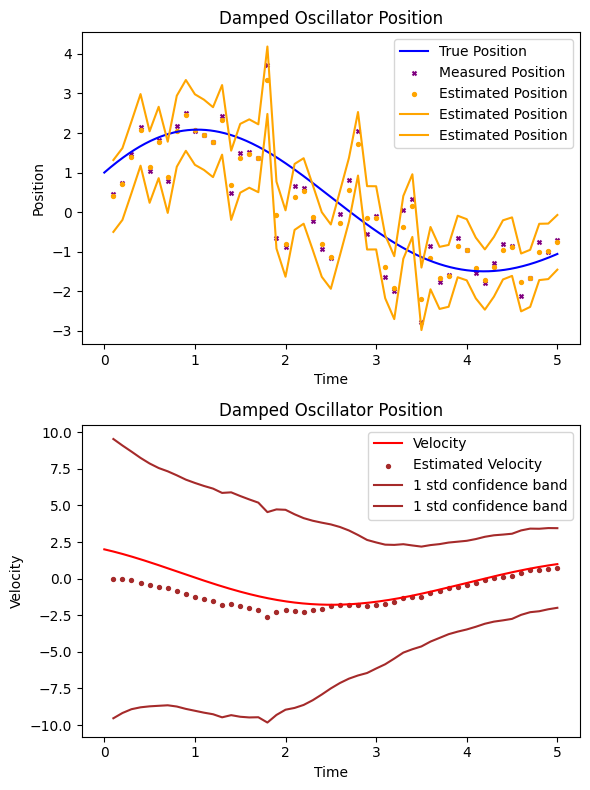

In [263]:
### Plot the "measurements" and estimations along side the true values


time2 = np.arange(0.1, T+tau, tau*10)

# Create plot side-by-side
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Plot the postion time series in the first subplot
axs[0].plot(time, x.T[0], label='True Position', color='blue')
axs[0].scatter(time2, synthetic_x, label='Measured Position', color='purple', marker='x', s=8)
axs[0].scatter(time2, est.T[0][1:], label='Estimated Position', color='orange', marker='o', s=8)
axs[0].plot(time2, est.T[0][1:]+dev.T[0][1:], label='Estimated Position', color='orange')
axs[0].plot(time2, est.T[0][1:]-dev.T[0][1:], label='Estimated Position', color='orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')
axs[0].set_title('Damped Oscillator Position')
axs[0].legend()

# Plot the velocity in the second subplot
axs[1].plot(time, x.T[1], label='Velocity', color='red')
axs[1].scatter(time2, est.T[1][1:], label='Estimated Velocity', color='brown', marker='o', s=8)
axs[1].plot(time2, est.T[1][1:]+dev.T[1][1:], label='1 std confidence band', color='brown')
axs[1].plot(time2, est.T[1][1:]-dev.T[1][1:], label='1 std confidence band', color='brown')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Velocity')
axs[1].set_title('Damped Oscillator Position')
axs[1].legend()

plt.tight_layout()
plt.show()

In [255]:
### Print the averaged squared error

real = x.T[0][1::10]
measurement_error = (1/len(real))*sum((real - synthetic_x)**2)
estimation_error = (1/len(real))*sum((real - est.T[0][1:])**2)
estimation_error_v = (1/len(real))*sum((real - est.T[1][1:])**2)

print(f'The quadratic error in the measurement (Position) is {measurement_error}')
print(f'The quadratic error in the estimation (Position) is {estimation_error}')
print(f'The quadratic error in the estimation (Velocity) is {estimation_error_v}')

The quadratic error in the measurement (Position) is 0.88131637303965
The quadratic error in the estimation (Position) is 0.6562425699265184
The quadratic error in the estimation (Velocity) is 5.886057267200846


### Exercise 1.5

Repeat the estimation, but now misspecifying the mode with $γ=0$ and $\omega=1.5$.

### Solution 1.5

In [256]:
m = np.array([0,0])
C = np.array([[10,0],[0,10]])
A2 = np.array([[0,1],[-1.5*1.5, 0]])
transition_matrix = np.linalg.inv(np.identity(len(A2)) - tau2*A2)
observation_matrix = np.array([1,0])


est2, dev2 = LKF(m, C, transition_matrix, observation_matrix, synthetic_x, 1)

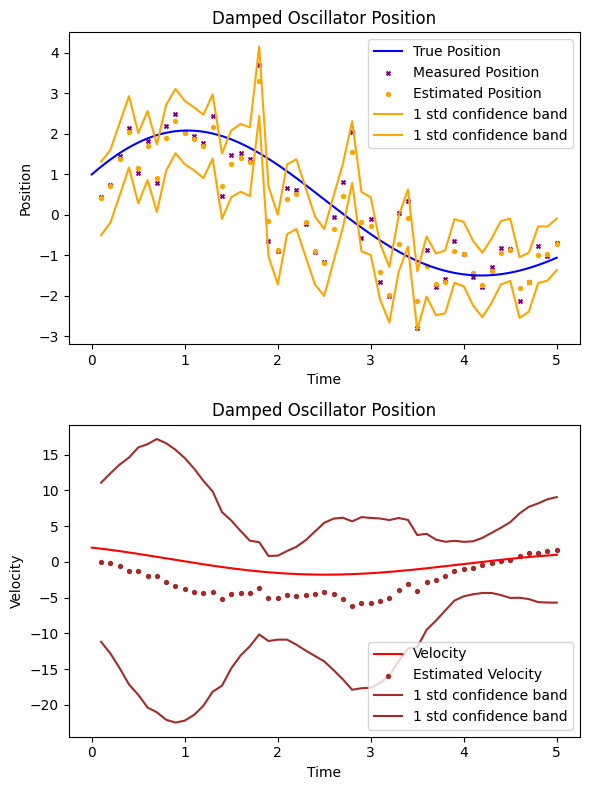

In [260]:
time2 = np.arange(0.1, T+tau, tau*10)

# Create plot side-by-side
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Plot the postion time series in the first subplot
axs[0].plot(time, x.T[0], label='True Position', color='blue')
axs[0].scatter(time2, synthetic_x, label='Measured Position', color='purple', marker='x', s=8)
axs[0].scatter(time2, est2.T[0][1:], label='Estimated Position', color='orange', marker='o', s=8)
axs[0].plot(time2, est2.T[0][1:]+dev2.T[0][1:], label='1 std confidence band', color='orange')
axs[0].plot(time2, est2.T[0][1:]-dev2.T[0][1:], label='1 std confidence band', color='orange')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')
axs[0].set_title('Damped Oscillator Position')
axs[0].legend()

# Plot the velocity in the second subplot
axs[1].plot(time, x.T[1], label='Velocity', color='red')
axs[1].scatter(time2, est2.T[1][1:], label='Estimated Velocity', color='brown', marker='o', s=8)
axs[1].plot(time2, est2.T[1][1:]+dev2.T[1][1:], label='1 std confidence band', color='brown')
axs[1].plot(time2, est2.T[1][1:]-dev2.T[1][1:], label='1 std confidence band', color='brown')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Velocity')
axs[1].set_title('Damped Oscillator Position')
axs[1].legend()

plt.tight_layout()
plt.show()

In [258]:
### Print the averaged squared error

real = x.T[0][1::10]
measurement_error_p = (1/len(real))*sum((real - synthetic_x)**2)
estimation_error_p = (1/len(real))*sum((real - est2.T[0][1:])**2)

estimation_error_v = (1/len(real))*sum((real - est2.T[1][1:])**2)

print(f'The quadratic error in the measurement (Position) is {measurement_error_p}')
print(f'The quadratic error in the estimation (Position) is {estimation_error_p}')
print(f'The quadratic error in the estimation (Velocity) is {estimation_error_v}')

The quadratic error in the measurement (Position) is 0.88131637303965
The quadratic error in the estimation (Position) is 0.6547045627135227
The quadratic error in the estimation (Velocity) is 19.131216488711345


#### Comments:

It is interest to notice that the filter were still able to provide an improvement in the Position estimation. Actually, repeating the exercise many times, the misspecified model provided a slightly lower measuremente error in the position.
The system is a damped oscillator. For $\gamma > 0$ the amplitude will decay with time and for $\gamma = 0$ with oscillate with the same amplitude. As our sample is short, the dampling is not "noticible". If our timelenght were longer, is likely that the misspecified would produce worst results (for position).

But in the Velocity estimation, the misspecified model were consireble worst.

### Exercise 1.6 (Optional)

How could you extend the ODE system to possibly allow for estimation of the parameters γ and ω along with the state x? What would be the obstacle to using the LKF for this task?

### Solution 1.6



Assuming that $\omega$ and $\gamma$ are fixed, we may augment our process as


$${x}_{aug}(t) = \begin{bmatrix} q(t) \\ \dot{q}(t) \\ \gamma_t \\ \omega^2_t \end{bmatrix}$$

and

$$A_{aug} = \begin{bmatrix} 0 & 1  &0 &0\\ -\omega_t^2 & -\gamma_t &0 &0 \\ 0&0&0&0 \\ 0&0&0&0 \end{bmatrix}$$

and

$$H = [1, 0, 0, 0]$$

Where the subscript $t$ represents the estimation at step $t$.

This augmentation would be innocuous for the process estimation. The Kalman Filter would keep $\gamma_t = \gamma_0$ and $\omega_t = \omega_0$.

Maybe if we add a process covariance $Q = diag([w_1, w_2, w_3, w_4])$ and modifie the Prediction Step from

$$\bar{C}_{j+1} = F\bar{C}_{j}F^T$$

to

$$\bar{C}_{j+1} = F\bar{C}_{j}F^T + Q$$

I believe this would allow the Kalman Filter to modify the values of  $\gamma_t$ and $\omega_t$.

The main challanges would be to set properly initial guesses and values for $w_i$.

If the system estimation is not too computationally intensive, I would sugest introduce a metric:

$$ \epsilon = \sum_{t = 0}^T \|\hat{C_t}\|$$

And find $\omega$, $\gamma$ which minimize $\epsilon$. Having more knowledge about the system, restrictions could be considered. The problem would be come:

$$ min_{\omega, \gamma} \sum_{t = 0}^T \|\hat{C_t}\|$$

s.t.

$$ \omega \in \mathbb{O}$$
$$ \gamma \in \mathbb{G}$$

Being $\mathbb{O}$ and $\mathbb{G}$ arbitrary restrictions.